# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import numpy as np
import torchvision
from tqdm import tqdm_notebook as tqdm

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))

from visualization.plots import plot_learning_curves, scrollable_loss_vs_hist, sorted_subset_weight_pairs

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import seaborn as sns

from matplotlib.animation import FuncAnimation

In [2]:
from pathlib import Path
import re

# Histograms

In [4]:
%matplotlib qt

In [5]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/mnist/1 hidden layer/40 neurons/train_from_scratch/'
run_num = 3
# ylim = 200

scrollable_loss_vs_hist(parent_dir, run_num, steps=20, net2net=False)

In [40]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/mnist/1 hidden layer/40 neurons/smart_init_noise_0.25/'
run_num = 3
# ylim = 200

scrollable_loss_vs_hist(parent_dir, run_num, steps=20, net2net=True)

In [37]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/mnist/1 hidden layer/40 neurons/smart_init_ortho_reg_rotation_noise_0.17/'
run_num = 3
# ylim = 200

scrollable_loss_vs_hist(parent_dir, run_num, steps=20, net2net=True)

In [37]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/mnist/2 hidden layers/30 neurons/train_from_scratch/'
run_num = 1
# ylim = 200

scrollable_loss_vs_hist(parent_dir, run_num, steps=40)

In [13]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/mnist/2 hidden layers/500 neurons/train_from_scratch/'
run_num = 2
# ylim = 200

scrollable_loss_vs_hist(parent_dir, run_num, steps=1)

In [91]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/mnist/1 hidden layer/40 neurons/train_from_scratch_net2net_at_start/'
run_num = 1
# ylim = 200

scrollable_loss_vs_hist(parent_dir, run_num, steps=40)

# Videos for presentation

In [7]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/mnist/1 hidden layer/40 neurons/train_from_scratch_net2net_at_start/'
run_num = 1
ylim = 500
steps = 40
net2net=False
speed_factor = 10

x = np.load(os.path.join(parent_dir, 'cos_dists_' + str(run_num) + '.npy'))
    
offset = 0
if net2net:
    offset = 40

loss_curve = np.load(parent_dir + 'loss_curve_' + str(run_num) + '.npy')

num_neurons = x.shape[1]
iu2 = np.triu_indices(num_neurons, k=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(loss_curve)
ax1.plot(1 + offset*46, loss_curve[1 + offset*46], marker='o')
ax1.set_title('Learning curve')
ax1.set_ylabel('Loss on Training Set')
ax1.set_xlabel('Training Time')

ax2 = fig.add_subplot(212)
ax2.set_xlim([-1, 1])
plots = x[0]
ax2.hist(plots[iu2], bins=50, range=(-1,1))
ax2.set_xlim([-1, 1])
if ylim is not None:
    ax2.set_ylim([0, ylim])
ax2.set_title('Histogram of cosine similarities')
ax2.set_xlabel('Cosine Similarity')

plt.tight_layout()
plt.show()

def animate(frame):

    curr_pos = steps*frame
    fake_pos = curr_pos

    ax1.cla()
    ax1.plot(loss_curve)
    ax1.plot(fake_pos + offset*46, loss_curve[fake_pos + offset*46], marker='o', label='time step ' + str(fake_pos))
    ax1.legend()
    ax1.set_title('Learning curve')
    ax1.set_ylabel('Loss on Training Set')
    ax1.set_xlabel('Training Time')

    ax2.cla()
    plots = x[curr_pos]
    ax2.hist(plots[iu2], bins=50, range=(-1,1))
    ax2.set_xlim([-1, 1])
    if ylim is not None:
        ax2.set_ylim([0, ylim])
    ax2.set_title('Histogram of cosine similarities')
    ax2.set_xlabel('Cosine Similarity')
    return

animation = FuncAnimation(
    # Your Matplotlib Figure object
    fig,
    # The function that does the updating of the Figure
    animate,
    # Frame information (here just frame number)
    np.arange(300),
    # Frame-time in ms; i.e. for a given frame-rate x, 1000/x
    interval=1000 / speed_factor,
    repeat=False
)

In [ ]:
animation.save('/home/manu/Presentations/WeightSymmetry/video_bottleneck.mp4')

# Archived Experiments (Not very useful)

# Mean vs Spread Visualization

In [3]:
%matplotlib inline

In [4]:
def reparametrize(weight_path):
    w_t = torch.load(weight_path)
#     w_t = w_t.dense_2.weight.data.cpu()
    w_t = F.normalize(w_t.dense_2.weight.data.cpu(), p=2, dim=1)
    
    num_neurons = w_t.shape[0]
    iu2 = np.triu_indices(num_neurons, k=1)
    
    u_t = w_t[iu2[0]] - w_t[iu2[1]]
    mw_t = 0.5*(w_t[iu2[0]] + w_t[iu2[1]])
    
    return mw_t, u_t

In [5]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/mnist/2 hidden layers/500 neurons - OG/train_from_scratch'
run_num = 0

weights_dir = os.path.join(parent_dir,'weight_history','run_0')

delta_w = []
delta_u = []
delta_u_norm = []

old_w_path = None

for i in range(len(os.listdir(weights_dir))-1):
    if old_w_path is None:
        old_w_path = os.path.join(weights_dir, 'epoch_'+ str(i+1) + '.pt')
        old_w, old_u = reparametrize(old_w_path)
    
    new_w_path = os.path.join(weights_dir, 'epoch_'+ str(i+2) + '.pt')
    
    new_w, new_u = reparametrize(new_w_path)
    
    delta_w.append(torch.norm(new_w-old_w, dim=1))
    delta_u.append(torch.norm(new_u-old_u, dim=1))
    delta_u_norm.append(torch.norm(new_u, dim=1)-torch.norm(old_u, dim=1))
    
    old_w_path = new_w_path
    old_w = new_w.clone()
    old_u = new_u.clone()

mean_delta_w = torch.stack(delta_w).mean(dim=0)
mean_delta_u = torch.stack(delta_u).mean(dim=0)
mean_delta_u_norm = torch.stack(delta_u_norm).mean(dim=0)

/home/manu/Software/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'nets.simpleNet.FCNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
cos_dists = np.load(os.path.join(parent_dir, 'cos_dists_' + str(run_num) + '.npy'))
num_neurons = cos_dists.shape[1]
iu2 = np.triu_indices(num_neurons, k=1)

x = cos_dists[0][iu2]

### Unnormalized

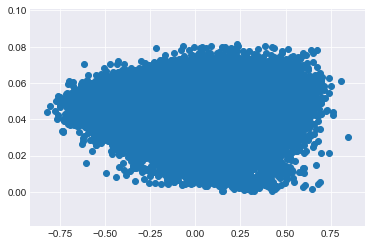

In [7]:
plt.figure()
plt.scatter(x,mean_delta_w)

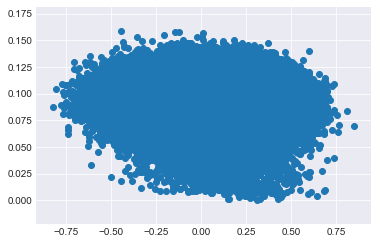

In [8]:
plt.figure()
plt.scatter(x,mean_delta_u)

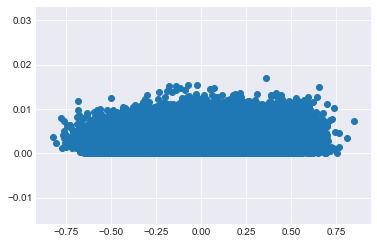

In [9]:
plt.figure()
plt.scatter(x,np.abs(mean_delta_u_norm))

### Normalized

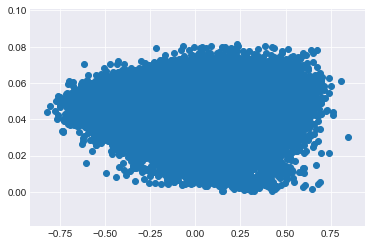

In [10]:
plt.figure()
plt.scatter(x,mean_delta_w)

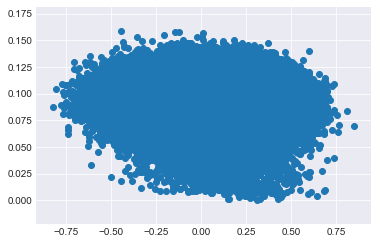

In [11]:
plt.figure()
plt.scatter(x,mean_delta_u)

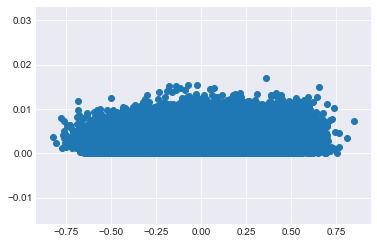

In [12]:
plt.figure()
plt.scatter(x,np.abs(mean_delta_u_norm))